In [879]:
from fontTools.subset import subset
from gplearn.genetic import SymbolicTransformer, SymbolicClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

In [880]:
df = pd.read_csv("Building_Permits.csv", low_memory=False)

In [881]:
df.head()

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,...,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID
0,201505065519,4,sign - erect,05/06/2015,0326,023,140,NaN,Ellis,St,...,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.785719256680785, -122.40852313194863)",1380611233945
1,201604195146,4,sign - erect,04/19/2016,0306,007,440,NaN,Geary,St,...,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.78733980600732, -122.41063199757738)",1420164406718
2,201605278609,3,additions alterations or repairs,05/27/2016,0595,203,1647,NaN,Pacific,Av,...,1.0,constr type 1,1.0,constr type 1,NaN,3.0,Russian Hill,94109.0,"(37.7946573324287, -122.42232562979227)",1424856504716
3,201611072166,8,otc alterations permit,11/07/2016,0156,011,1230,NaN,Pacific,Av,...,5.0,wood frame (5),5.0,wood frame (5),NaN,3.0,Nob Hill,94109.0,"(37.79595867909168, -122.41557405519474)",1443574295566
4,201611283529,6,demolitions,11/28/2016,0342,001,950,NaN,Market,St,...,3.0,constr type 3,NaN,NaN,NaN,6.0,Tenderloin,94102.0,"(37.78315261897309, -122.40950883997789)",144548169992


In [882]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198900 entries, 0 to 198899
Data columns (total 43 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   Permit Number                           198900 non-null  object 
 1   Permit Type                             198900 non-null  int64  
 2   Permit Type Definition                  198900 non-null  object 
 3   Permit Creation Date                    198900 non-null  object 
 4   Block                                   198900 non-null  object 
 5   Lot                                     198900 non-null  object 
 6   Street Number                           198900 non-null  int64  
 7   Street Number Suffix                    2216 non-null    object 
 8   Street Name                             198900 non-null  object 
 9   Street Suffix                           196132 non-null  object 
 10  Unit                                    2947

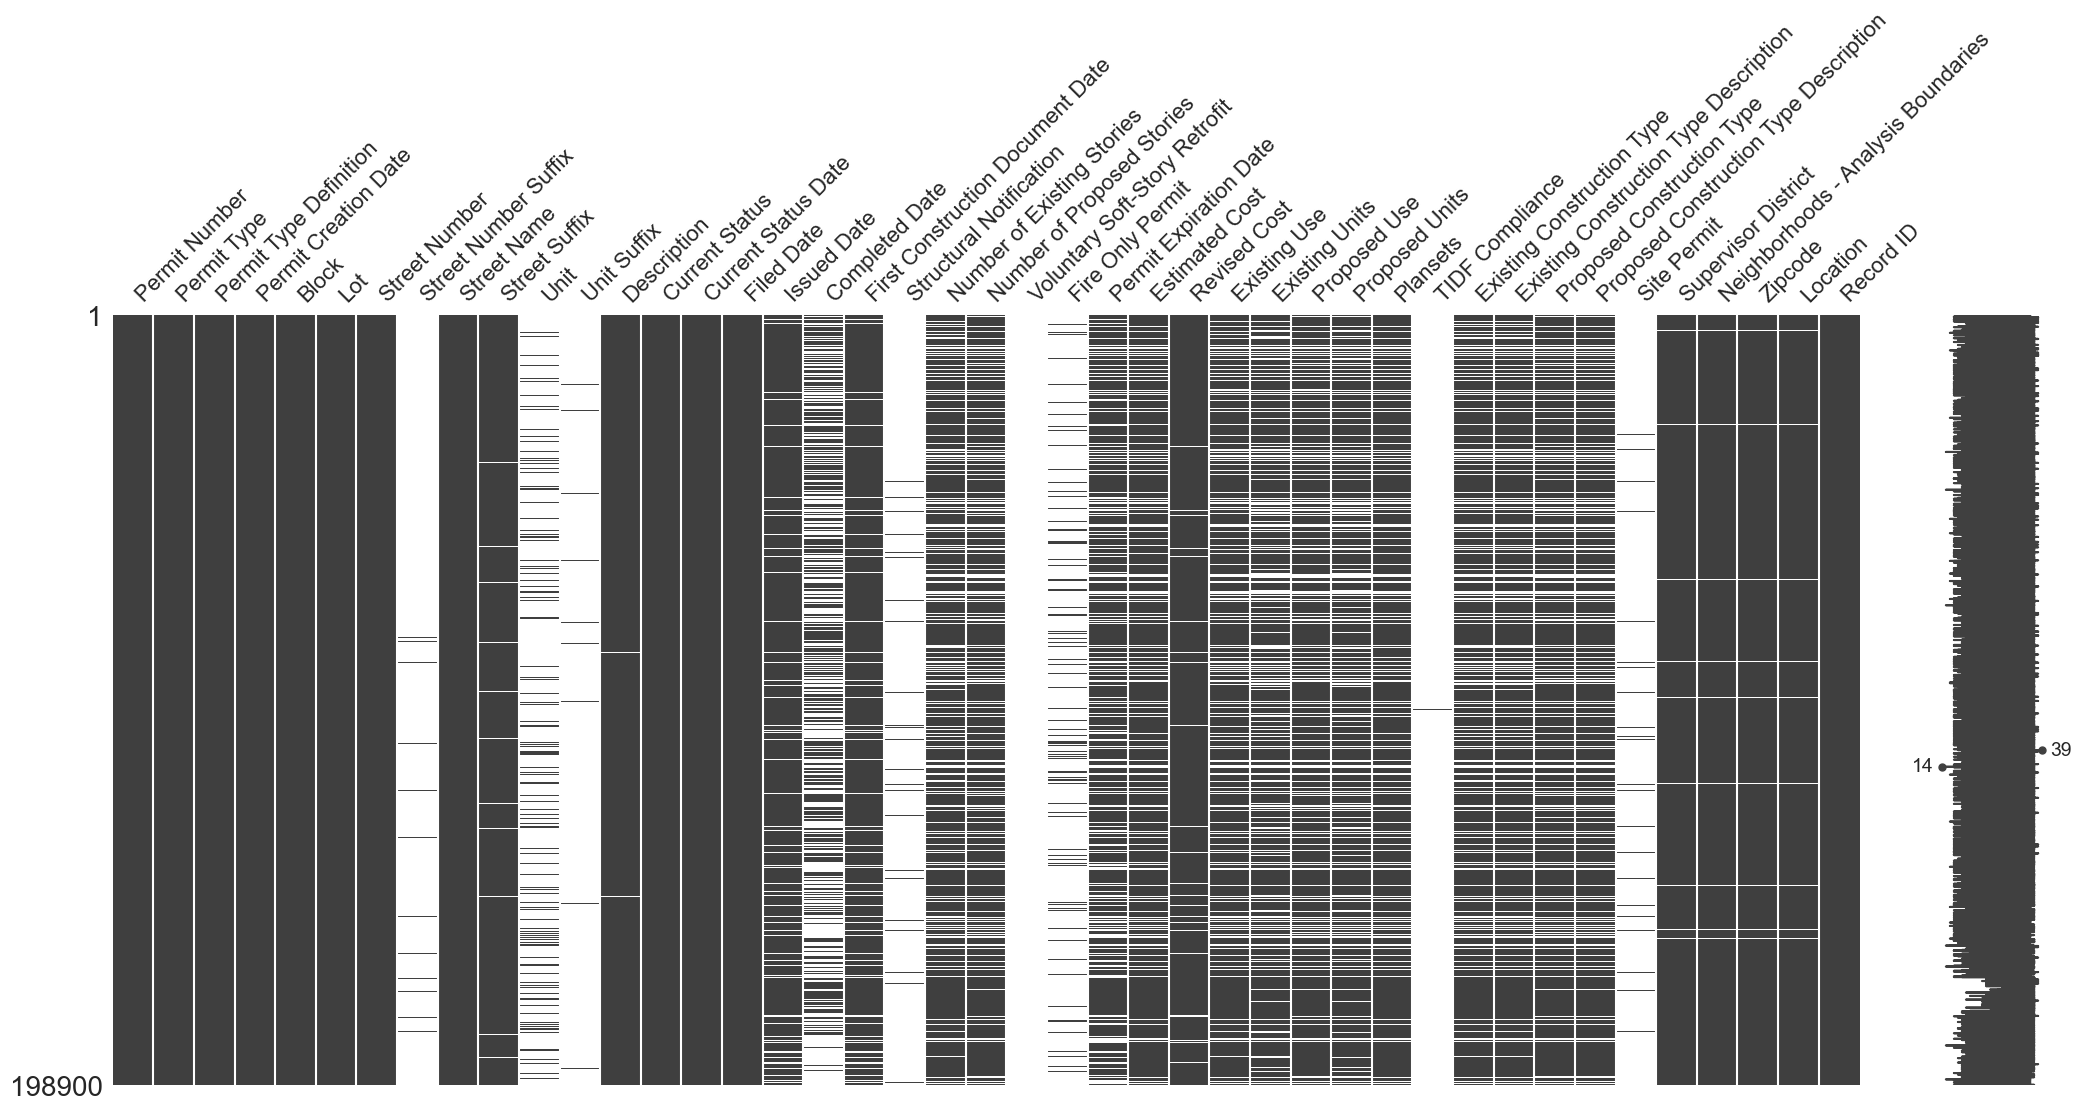

In [883]:
msno.matrix(df)
plt.show()

In [884]:
df = df.dropna(subset=['Issued Date'])

In [885]:
df[['Filed Date', 'Issued Date']] = df[['Filed Date', 'Issued Date']].apply(pd.to_datetime)

In [886]:
df['Permit Processig Time'] = (df['Issued Date'] - df['Filed Date']).dt.days

In [887]:
df = df.drop(
    columns=['Permit Number', 'Record ID', 'Site Permit', 'Current Status', 'Current Status Date', 'Completed Date',
             'Permit Expiration Date', 'Permit Creation Date', 'First Construction Document Date', 'Filed Date',
             'Issued Date', 'Street Number', 'Street Number Suffix', 'Street Name', 'Street Number Suffix', 'Unit',
             'Unit Suffix', 'Location', 'Block', 'Lot', 'TIDF Compliance', 'Voluntary Soft-Story Retrofit'])

In [888]:
df['Street Suffix'].info()
df['Street Suffix'].describe()
df['Street Suffix'].value_counts()

<class 'pandas.core.series.Series'>
Index: 183960 entries, 0 to 198899
Series name: Street Suffix
Non-Null Count   Dtype 
--------------   ----- 
181368 non-null  object
dtypes: object(1)
memory usage: 2.8+ MB


Street Suffix
St    127734
Av     40103
Wy      3345
Bl      3243
Dr      3076
Tr      1368
Ct       643
Pl       472
Ln       335
Rd       331
Hy       222
Pz       193
Pk       118
Cr        91
Al        74
Wk         8
Rw         5
So         2
Sw         2
No         2
Hl         1
Name: count, dtype: int64

In [889]:
df['Street Suffix'] = df['Street Suffix'].fillna('Unknown')

In [890]:
df['Structural Notification'].info()
df['Structural Notification'].describe()
df['Structural Notification'].value_counts()

<class 'pandas.core.series.Series'>
Index: 183960 entries, 0 to 198899
Series name: Structural Notification
Non-Null Count  Dtype 
--------------  ----- 
5210 non-null   object
dtypes: object(1)
memory usage: 2.8+ MB


Structural Notification
Y    5210
Name: count, dtype: int64

In [891]:
df['Structural Notification'] = df['Structural Notification'].fillna('Unknown')

In [892]:
df['Number of Existing Stories'].info()
df['Number of Existing Stories'].describe()

<class 'pandas.core.series.Series'>
Index: 183960 entries, 0 to 198899
Series name: Number of Existing Stories
Non-Null Count   Dtype  
--------------   -----  
143203 non-null  float64
dtypes: float64(1)
memory usage: 2.8 MB


count    143203.000000
mean          5.809253
std           8.758812
min           0.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          78.000000
Name: Number of Existing Stories, dtype: float64

In [893]:
df['Number of Existing Stories'] = df['Number of Existing Stories'].replace({1.5: 1, 2.5: 2})
df['Number of Existing Stories'] = df['Number of Existing Stories'].astype('Int64')
Q1 = df['Number of Existing Stories'].quantile(0.25)
Q3 = df['Number of Existing Stories'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)
print('Lower bound: ', lower_bound, '\nUpper bound: ', upper_bound)

Lower bound:  -1.0 
Upper bound:  7.0


In [894]:
upper_bound = upper_bound - lower_bound
lower_bound = lower_bound - lower_bound
df = df[(df['Number of Existing Stories'] >= lower_bound) & (df['Number of Existing Stories'] <= upper_bound)]
df['Number of Existing Stories'].info()
df['Number of Existing Stories'].describe()
df['Number of Existing Stories'].value_counts()

<class 'pandas.core.series.Series'>
Index: 123462 entries, 0 to 198896
Series name: Number of Existing Stories
Non-Null Count   Dtype
--------------   -----
123462 non-null  Int64
dtypes: Int64(1)
memory usage: 2.0 MB


Number of Existing Stories
2    49082
3    41407
4    14100
1     7908
5     3433
6     3390
7     2165
8     1571
0      406
Name: count, dtype: Int64

In [895]:
df['Number of Proposed Stories'].info()
df['Number of Proposed Stories'].describe()

<class 'pandas.core.series.Series'>
Index: 123462 entries, 0 to 198896
Series name: Number of Proposed Stories
Non-Null Count   Dtype  
--------------   -----  
121165 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB


count    121165.000000
mean          2.884187
std           1.396607
min           0.000000
25%           2.000000
50%           3.000000
75%           3.000000
max          63.000000
Name: Number of Proposed Stories, dtype: float64

In [896]:
df['Number of Proposed Stories'] = df['Number of Proposed Stories'].replace({1.5: 1, 2.5: 2})
df['Number of Proposed Stories'] = df['Number of Proposed Stories'].astype('Int64')
Q1 = df['Number of Proposed Stories'].quantile(0.25)
Q3 = df['Number of Proposed Stories'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)
print('Lower bound: ', lower_bound, '\nUpper bound: ', upper_bound)

Lower bound:  0.5 
Upper bound:  4.5


In [897]:
upper_bound = upper_bound + lower_bound
lower_bound = lower_bound - lower_bound
df = df[(df['Number of Proposed Stories'] >= lower_bound) & (df['Number of Proposed Stories'] <= upper_bound)]
df['Number of Proposed Stories'].info()
df['Number of Proposed Stories'].describe()
df['Number of Proposed Stories'].value_counts()

<class 'pandas.core.series.Series'>
Index: 114224 entries, 3 to 198896
Series name: Number of Proposed Stories
Non-Null Count   Dtype
--------------   -----
114224 non-null  Int64
dtypes: Int64(1)
memory usage: 1.9 MB


Number of Proposed Stories
2    47549
3    41456
4    14557
1     7131
5     3392
0      139
Name: count, dtype: Int64

In [898]:
df['Fire Only Permit'].info()
df['Fire Only Permit'].describe()
df['Fire Only Permit'].value_counts()

<class 'pandas.core.series.Series'>
Index: 114224 entries, 3 to 198896
Series name: Fire Only Permit
Non-Null Count  Dtype 
--------------  ----- 
7685 non-null   object
dtypes: object(1)
memory usage: 1.7+ MB


Fire Only Permit
Y    7685
Name: count, dtype: int64

In [899]:
df['Fire Only Permit'] = df['Fire Only Permit'].fillna('N')

In [900]:
df['Existing Units'].info()
df['Existing Units'].describe()

<class 'pandas.core.series.Series'>
Index: 114224 entries, 3 to 198896
Series name: Existing Units
Non-Null Count   Dtype  
--------------   -----  
110986 non-null  float64
dtypes: float64(1)
memory usage: 1.7 MB


count    110986.000000
mean          5.880303
std          19.030415
min           0.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         720.000000
Name: Existing Units, dtype: float64

In [901]:
df['Existing Units'] = df['Existing Units'].replace({0.3: 1})
df['Existing Units'] = df['Existing Units'].astype('Int64')
Q1 = df['Existing Units'].quantile(0.25)
Q3 = df['Existing Units'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)
print('Lower bound: ', lower_bound, '\nUpper bound: ', upper_bound)

Lower bound:  -3.5 
Upper bound:  8.5


In [902]:
upper_bound = upper_bound - lower_bound
lower_bound = lower_bound - lower_bound
df = df[(df['Existing Units'] >= lower_bound) & (df['Existing Units'] <= upper_bound)]
df['Existing Units'].info()
df['Existing Units'].describe()
df['Existing Units'].value_counts()

<class 'pandas.core.series.Series'>
Index: 101399 entries, 3 to 198896
Series name: Existing Units
Non-Null Count   Dtype
--------------   -----
101399 non-null  Int64
dtypes: Int64(1)
memory usage: 1.6 MB


Existing Units
1     44020
2     20261
0     10773
3      8029
4      5017
6      4844
12     2128
5      1950
8      1441
7       984
9       959
10      635
11      358
Name: count, dtype: Int64

In [903]:
df['Existing Construction Type'].info()
df['Existing Construction Type'].describe()
df['Existing Construction Type'].value_counts()

<class 'pandas.core.series.Series'>
Index: 101399 entries, 3 to 198896
Series name: Existing Construction Type
Non-Null Count   Dtype  
--------------   -----  
100996 non-null  float64
dtypes: float64(1)
memory usage: 1.5 MB


Existing Construction Type
5.0    93507
3.0     3866
1.0     2043
2.0     1381
4.0      199
Name: count, dtype: int64

In [904]:
df = df.dropna(subset=['Existing Construction Type'])

In [905]:
df['Estimated Cost'].info()
df['Estimated Cost'].describe()

<class 'pandas.core.series.Series'>
Index: 100996 entries, 3 to 198896
Series name: Estimated Cost
Non-Null Count   Dtype  
--------------   -----  
100889 non-null  float64
dtypes: float64(1)
memory usage: 1.5 MB


count    1.008890e+05
mean     4.318718e+04
std      2.292915e+05
min      1.000000e+00
25%      3.500000e+03
50%      1.000000e+04
75%      2.700000e+04
max      2.800000e+07
Name: Estimated Cost, dtype: float64

In [906]:
Q1 = df['Estimated Cost'].quantile(0.25)
Q3 = df['Estimated Cost'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)
print('Lower bound: ', lower_bound, '\nUpper bound: ', upper_bound)

Lower bound:  -31750.0 
Upper bound:  62250.0


In [907]:
upper_bound = upper_bound - lower_bound
lower_bound = lower_bound - lower_bound
print('Lower bound: ', lower_bound, '\nUpper bound: ', upper_bound)
df = df[(df['Estimated Cost'] >= lower_bound) & (df['Estimated Cost'] <= upper_bound)]
df['Estimated Cost'].info()
df['Estimated Cost'].describe()

Lower bound:  0.0 
Upper bound:  94000.0
<class 'pandas.core.series.Series'>
Index: 93537 entries, 3 to 198896
Series name: Estimated Cost
Non-Null Count  Dtype  
--------------  -----  
93537 non-null  float64
dtypes: float64(1)
memory usage: 1.4 MB


count    93537.000000
mean     15950.599118
std      18920.541543
min          1.000000
25%       3000.000000
50%       9300.000000
75%      20000.000000
max      94000.000000
Name: Estimated Cost, dtype: float64

In [908]:
df['Supervisor District'].info()
df['Supervisor District'].value_counts()
df['Supervisor District'].describe()

<class 'pandas.core.series.Series'>
Index: 93537 entries, 3 to 198896
Series name: Supervisor District
Non-Null Count  Dtype  
--------------  -----  
93014 non-null  float64
dtypes: float64(1)
memory usage: 1.4 MB


count    93014.000000
mean         5.888350
std          3.079286
min          1.000000
25%          3.000000
50%          7.000000
75%          8.000000
max         11.000000
Name: Supervisor District, dtype: float64

In [909]:
df['Supervisor District'] = df['Supervisor District'].fillna(5.888350)

In [910]:
df = df.dropna(subset=['Existing Use'])

In [911]:
df['Neighborhoods - Analysis Boundaries'].info()
df['Neighborhoods - Analysis Boundaries'].describe()

<class 'pandas.core.series.Series'>
Index: 93465 entries, 3 to 198896
Series name: Neighborhoods - Analysis Boundaries
Non-Null Count  Dtype 
--------------  ----- 
92938 non-null  object
dtypes: object(1)
memory usage: 1.4+ MB


count               92938
unique                 41
top       Sunset/Parkside
freq                 7934
Name: Neighborhoods - Analysis Boundaries, dtype: object

In [912]:
df = df.dropna(subset=['Neighborhoods - Analysis Boundaries'])

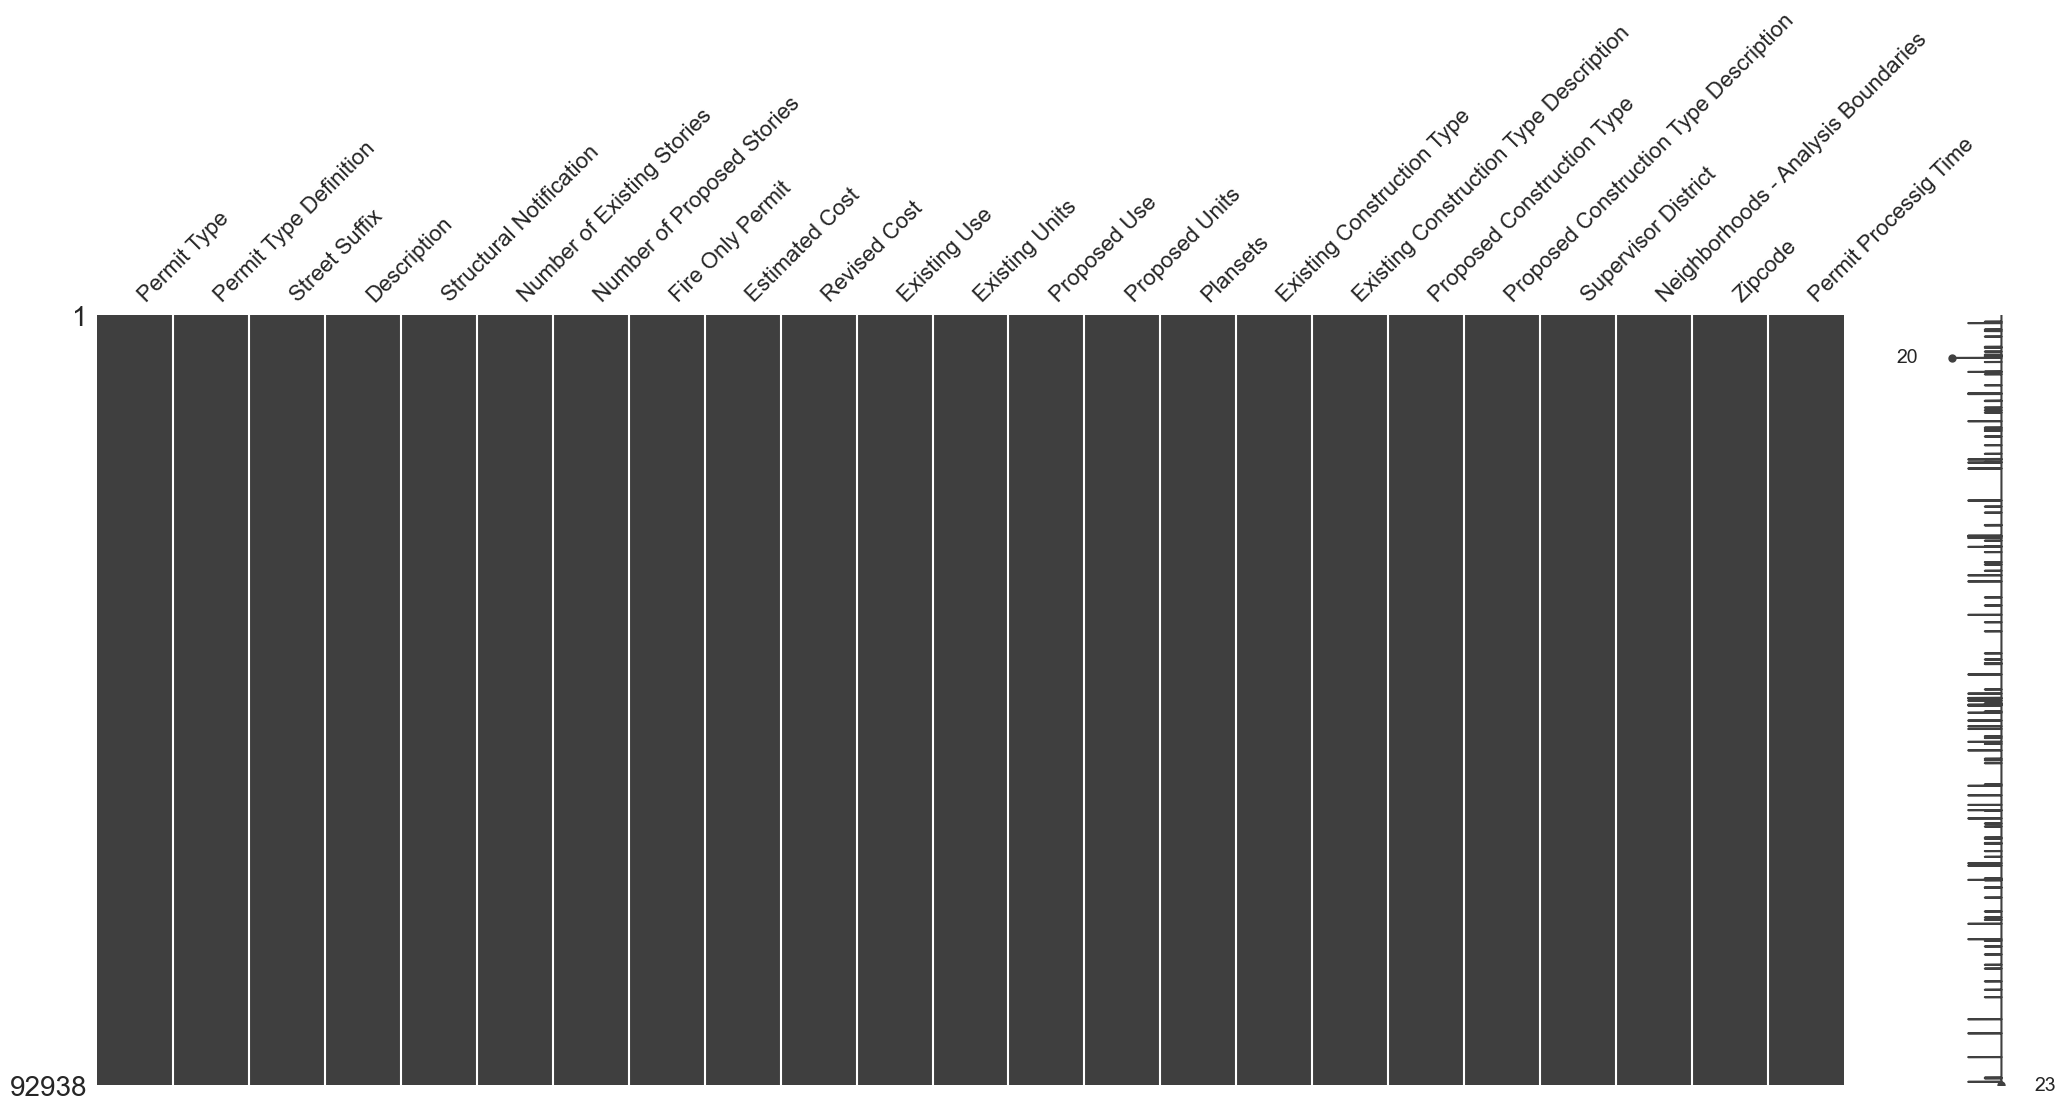

In [913]:
msno.matrix(df)
plt.show()

In [914]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 92938 entries, 3 to 198882
Data columns (total 23 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Permit Type                             92938 non-null  int64  
 1   Permit Type Definition                  92938 non-null  object 
 2   Street Suffix                           92938 non-null  object 
 3   Description                             92925 non-null  object 
 4   Structural Notification                 92938 non-null  object 
 5   Number of Existing Stories              92938 non-null  Int64  
 6   Number of Proposed Stories              92938 non-null  Int64  
 7   Fire Only Permit                        92938 non-null  object 
 8   Estimated Cost                          92938 non-null  float64
 9   Revised Cost                            92937 non-null  float64
 10  Existing Use                            92938 non-null  object

,Permit Type,Permit Type Definition,Street Suffix,Description,Structural Notification,Number of Existing Stories,Number of Proposed Stories,Fire Only Permit,Estimated Cost,Revised Cost,...,Proposed Units,Plansets,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Permit Processig Time
3,8,otc alterations permit,Av,repair dryrot & stucco at front of bldg.,Unknown,2,2,N,2000.0,2000.0,...,1.0,2.0,5.0,wood frame (5),5.0,wood frame (5),3.0,Nob Hill,94109.0,253
6,8,otc alterations permit,Av,re-roofing,Unknown,3,3,N,12000.0,12000.0,...,5.0,0.0,5.0,wood frame (5),5.0,wood frame (5),5.0,Inner Sunset,94122.0,0
24,8,otc alterations permit,Ct,re-roofing,Unknown,4,4,N,64650.0,64650.0,...,9.0,0.0,5.0,wood frame (5),5.0,wood frame (5),2.0,Marina,94123.0,0
25,8,otc alterations permit,Av,re-roofing,Unknown,2,2,N,7000.0,7000.0,...,1.0,0.0,5.0,wood frame (5),5.0,wood frame (5),4.0,Sunset/Parkside,94122.0,0
48,8,otc alterations permit,St,reroofing,Unknown,2,2,N,14000.0,14000.0,...,1.0,0.0,5.0,wood frame (5),5.0,wood frame (5),9.0,Portola,94134.0,0
